# <center> Support Vector Machine<br> <small>Réda DEHAK<br> 14 January 2020</small> </center>

The goal of this lab is :
    - Test SVM Methods on classification problems
    
We will use the [Wine dataset](https://archive.ics.uci.edu/ml/datasets/Wine) from UCI. These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of thirteen constituents found in each of the three types of wines.

# Part 1: Own implementation of SVM class

We will try first to implement our own SVM class to perform an SVM classifier using the <A href=https://cvxopt.org/userguide/coneprog.html#quadratic-programming> cvxopt.solvers.qp </A> solver 

1- Try first to implement myOwnHardSVM

- SVM training consists of solving the double problem defined by:
\begin{align}
\text{Maximize:} & Q(\alpha) = \sum_i \alpha_i - \frac{1}{2} \sum_i\sum_j \alpha_i \alpha_j y_i y_j G[i,j]\\
\text{Subject to:} & \sum_i \alpha_i y_i =0\\
& \alpha_i \ge 0
\end{align}

Where $G$ represents the Gram Matrix and is defined by:
$$G[i, j]= \left< x_i, x_j\right>$$

In [52]:
from cvxopt.solvers import qp
from cvxopt import matrix
import numpy as np

EPS=1E-5

class myOwnHardSVM:
    def init(self):
        self.W = None
        self.b = None
        self.alphas = None
        self.SVs = None
    
    def fit(self, DataTrain, labels):
        DataTrain = np.asarray(DataTrain)
        labels = np.asarray(labels)
        labels = labels.reshape((1, -1))
        
        N = len(DataTrain)
        q = matrix(-np.ones((N, 1)), size = (N, 1), tc='d')
        P = matrix((labels.T @ labels) *(DataTrain @ DataTrain.T), size = (N, N), tc = 'd')
        A = matrix(labels, size = (1, N), tc = 'd')
        b = matrix(np.zeros((1,1)), size = (1,1), tc = 'd')
        G = matrix(-np.eye(N), size = (N, N), tc = 'd')
        h = matrix(np.zeros((N,1)), size = (N,1), tc = 'd')
        res = qp(P, q, G, h, A, b)
        if res['status'] == 'optimal':
            id = np.where(np.array(res['x']) > EPS)[0]
            self.alphas = np.array(res['x'])[id].reshape(-1, 1) * labels[0, id].reshape(-1,1)
            self.SVs = DataTrain[id, :]
            # w = sum y_i alpha_i sv_i
            self.W = self.SVs.T @ self.alphas
            # b = 1/Nsv sum (y_i - w.T sv_i)
            self.b = 1 / len(id) * np.sum(labels[0,id]-self.W.T @ self.SVs.T)
        else:
            print('The solution is not optimal')

        return self
    
    def decision_function(self, data):
        return self.W.T @ data.T + self.b
    
    def predict(self, data):
        return np.sign(self.decision_function(data))

- Test your myOwnHardSVM class on this simple dataset $\left\{\left(1; -1\right), \left(2; +1\right), \left(3; +1\right)\right\}$. Did you obtain a coherent results

In [53]:
mySVM = myOwnHardSVM().fit(np.array([[1], [2], [3]]), np.array([-1, 1, 1]))
print(mySVM)

     pcost       dcost       gap    pres   dres
 0: -1.1111e+00 -2.4444e+00  5e+00  2e+00  2e+00
 1: -2.0801e+00 -2.0579e+00  1e-01  1e-01  1e-01
 2: -2.0000e+00 -2.0008e+00  2e-03  9e-04  9e-04
 3: -2.0000e+00 -2.0000e+00  2e-05  9e-06  9e-06
 4: -2.0000e+00 -2.0000e+00  2e-07  9e-08  9e-08
Optimal solution found.


In [54]:
print(mySVM.alphas, mySVM.SVs)

[[-1.99999986]
 [ 1.99999986]] [[1]
 [2]]


In [55]:
print(mySVM.W, mySVM.b)

[[1.99999986]] -2.999999795062309


- Generate a tiny 2D linearly separable 2 classes problem and test your myOwnHardSVM. Plot the boundary and check your result. Try to adapt the function plot_boundary to show the margin and the support vector.

In [63]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)
    plt.contour(xs, ys, zs, colors='black', levels=[0])
    plt.contour(xs, ys, zs, colors='black', linestyles='dashed', levels=[-1, +1])

In [64]:
Data = np.array([[1, 2], [2, 3], [1, 3], [2, 0], [3, 0], [3, 1]])
Labels = np.array([1, 1, 1, -1, -1, -1])
mySVM2= myOwnHardSVM().fit(Data, Labels)

     pcost       dcost       gap    pres   dres
 0: -6.1287e-01 -1.3237e+00  9e+00  3e+00  1e+00
 1: -1.4733e-01 -1.1348e+00  1e+00  4e-16  4e-16
 2: -4.0193e-01 -4.8819e-01  9e-02  2e-16  6e-16
 3: -4.4316e-01 -4.4506e-01  2e-03  6e-17  4e-16
 4: -4.4443e-01 -4.4445e-01  2e-05  6e-17  6e-16
 5: -4.4444e-01 -4.4444e-01  2e-07  1e-16  4e-16
Optimal solution found.


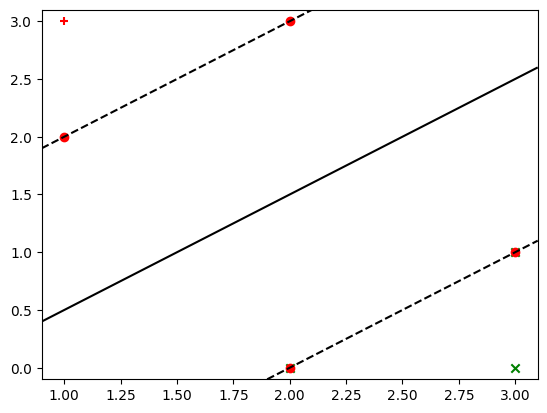

In [67]:
plot_points(Data, Labels)
plot_boundary(Data, lambda x:mySVM2.decision_function(x))
plt.scatter(mySVM2.SVs[:,0], mySVM2.SVs[:,1], marker='o', color='red')

- Try now your myOwnHardSVM with a training dataset which is not linearly separable, what did you remark?

2- We try now to implement the sof margin SVM class

In [ ]:
class myOwnSoftSVM(myOwnHardSVM):
    
    def init(self, C=1.):
        pass
    
    ...

- Test your myOwnSoftSVM class on your previous training dataset which is not linearly separable.

# Part 2: Wine dataset and sklearn.svm.svc class

## Loading and Plotting Data
 
First, we will use only two features from the data set: alcohol and ash (We can plot the solution in 2D space). The labels are supplied as an array of data with values from 1 to 3, but at first, we want a simple binary regression problem with a yes or no answer.  

We filter the data set, reducing it to only include wines with labels 1 or 2.  

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

data = pd.read_csv('data.txt')

reduced = data[data['class'] <= 2]
X = reduced[['alcohol', 'ash']].to_numpy()
y = label_binarize(reduced['class'].values, classes=[1, 2])[:,0]

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state = 42)
print('train:', len(Xtrain), 'test:', len(Xtest))

In [ ]:
plot_points(Xtrain, ytrain)

We can see that we can plot line that could divide the two colored points with a small amount of error.

# Linear SVM

- Using SVC class of sklearn.svm train a linear SVM

In [ ]:
from sklearn.svm import SVC

...

- print the dual parameters $\alpha$

In [ ]:
...

- Plot the linear separator, show the margin and the support vector. 

- Which training examples are misclassified? compute the slack variables $\zeta_i$ for these samples

- Compute the confusion matrix, the accuray, the precision and the recall on the test data? 

- Compute the accuray, the precision, the recall and the confusion matrix of your classifieur? what did you conclude? 

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score

...

# Multiclass SVM

The next step is something more interesting: we use a similar set of two features from the data set (this time alcohol and flavanoids), but with all three labels instead of two.

In [ ]:
X = data[['alcohol', 'flavanoids']].to_numpy()
y = data['class'].to_numpy()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state = 42)

plot_points(Xtrain, ytrain)

The plotted data points again suggest some obvious linear boundaries between the three classes.


- Train and Test a linear SVM using the method one against rest

In [ ]:
...

- Train and Test a linear SVM using the method one against one

In [ ]:
...

- compare the result of the two methods?

In [ ]:
...

# Practice

Next, we want to include all the features from the data set.  

In [ ]:
X = data.drop('class', 1).to_numpy()
y = data['class'].to_numpy()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state = 42)

Because we are now significantly increasing the number of features, since we have few training example we need to prevent overfitting.

- Train and test a SVM classifier solution in this case

In [ ]:
...

- Conclude, What is your remarks about overfitting and generalisation compared to the previous results?